In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from lmfit import Model
import datetime


In [28]:
# load data
file = 'D:/O2_Calibration_Images/RAW_2023-09-05/red_green_ratio.csv'
data = pd.read_csv(file, decimal=',')
print(data)


    Temperature/O2  Intensity Ratio  Intensity Red  Intensity Green  \
0              0.0         1.937844    2397.163129      1236.156118   
1             10.9         1.707457    1935.447641      1133.013886   
2             20.2         1.564003    1687.364432      1078.515779   
3             30.3         1.449972    1508.988059      1040.410006   
4             40.5         1.362825    1381.662875      1013.591378   
5             50.3         1.296562    1287.521848       992.868551   
6             60.6         1.237720    1206.743561       974.867214   
7             70.2         1.191890    1146.510302       961.876594   
8             80.3         1.149345    1092.289775       950.346186   
9             90.2         1.111966    1044.536352       939.383577   
10            99.2         1.079104     999.732900       926.457593   
11             0.0         1.939248    2412.843951      1243.344084   
12            10.9         1.703062    1940.687547      1138.993389   
13    

In [29]:
# Group the data by Air Saturation and calculate the mean ratio for each air saturation value
grouped_data = data.groupby('Temperature/O2').mean()#.round(4)
print(grouped_data)

# Get the R0 value: Intensity Ratio at Air Saturation = 0%
R0 = grouped_data.iloc[0, 0]
print('this is R0', R0)

# Normalize the data by R0/R
grouped_data['Intensity Ratio'] = R0 / grouped_data['Intensity Ratio']  
print(grouped_data)


                Intensity Ratio  Intensity Red  Intensity Green  \
Temperature/O2                                                    
0.0                    1.938705    2406.897197      1240.625919   
10.9                   1.703126    1936.798004      1136.663298   
20.2                   1.561268    1690.066870      1082.088187   
30.3                   1.448146    1510.519610      1042.741445   
40.5                   1.361405    1381.596754      1014.589909   
50.3                   1.295227    1287.555699       993.903127   
60.6                   1.237045    1207.365957       975.894938   
70.2                   1.191352    1147.767784       963.364343   
80.3                   1.148966    1093.013796       951.286331   
90.2                   1.111757    1045.732622       940.630972   
99.2                   1.079208    1003.479302       929.838114   

                Intensity Blue  Std Ratio     Std Red  Std Green   Std Blue  
Temperature/O2                                    

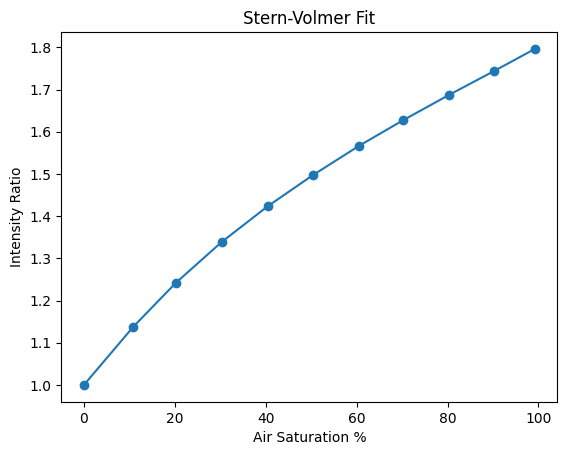

In [30]:
# Create a plot
plt.plot(grouped_data.index, grouped_data['Intensity Ratio'], 'o-')

# Set the x-axis and y-axis labels
plt.title('Stern-Volmer Fit')
plt.xlabel('Air Saturation %')
plt.ylabel('Intensity Ratio')
plt.show()

In [31]:
# define simplified Stern-Volmer function
def _sternvolmer_simple(x, f, k):
    """
    fitting function according to the common two site model. In general, x represents the pO2 or pCO2 content, whereas
    m, k and f are the common fitting parameters
    :param x:   list
    :param k:   np.float
    :param f:   np.float
    :return:
    """
    # R0/R
    int_ratio = 1 / (f / (1. + k*x) + (1.-f))
    return int_ratio
 

# make your function a model to be used by lmfit
simple_sv = Model(_sternvolmer_simple)

In [32]:
# set initial parameter
params_sens = simple_sv.make_params(k=0.165, f=0.887) # from previous calibrations approximately known
params_sens['k'].min = 0.
params_sens['f'].max = 1.

# use R0/R data for fit and re-calculate i afterwards
# full concentration range
ytofit_sens = grouped_data['Intensity Ratio'].to_numpy()
xtofit_sens = grouped_data.index.to_numpy() 
result = simple_sv.fit(ytofit_sens, params_sens, x=xtofit_sens, nan_policy='omit')

[[Model]]
    Model(_sternvolmer_simple)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3
    # data points      = 11
    # variables        = 1
    chi-square         = 1.8477e-04
    reduced chi-square = 1.8477e-05
    Akaike info crit   = -118.936988
    Bayesian info crit = -118.539093
    R-squared          = 0.99972213
[[Variables]]
    f:  0.66081665 +/- 9.9552e-04 (0.15%) (init = 0.6608166)
    k:  0.02019263 (fixed)


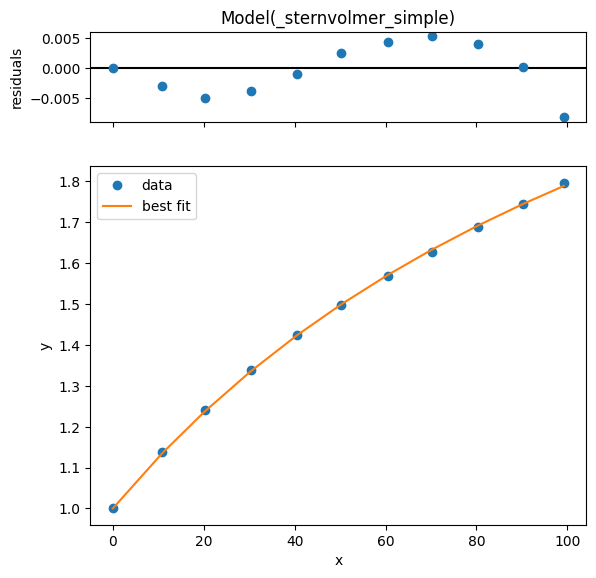

In [33]:
# to optimize the fit (and be sure of the parameter) >> 2nd round with one parameter fixed
params_sens2 = params_sens.copy()
params_sens2['k'].value = result.best_values['k']
params_sens2['k'].vary = False
params_sens2['f'].value = result.best_values['f']

params_sens2['f'].min = 0.
params_sens2['f'].max = 1.
result2 = simple_sv.fit(ytofit_sens, params_sens2, x=xtofit_sens, nan_policy='omit')

df_bestFit_preSens_norm = pd.DataFrame(1 / result2.best_fit, index=xtofit_sens)
df_bestFit_preSens = pd.DataFrame(grouped_data.loc[0, 'Intensity Ratio'] / result2.best_fit, index=xtofit_sens)
result2.best_values
fit_report = result2.fit_report()
print(fit_report)
result2.plot()
plt.show()



In [14]:
# SAVE THE RESULT
# best fit for parameter done... save report
import datetime

now = datetime.datetime.now()
time_now = now.strftime('%Y%m%d-%H%M%S')

# save fit report to a file
with open('C:/Users/au519867/OneDrive - Aarhus universitet/Skrivebord/' + time_now + '_fit_result.txt', 'w') as fh:
    fh.write(fit_report)
